# Distributed Hyper-parameter searching

In [1]:
%matplotlib inline

import time
import random
import threading
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (2, 2)

from cclyde import Cluster
from distributed import Client, progress
from pprint import pprint


from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits

---
## Create and launch AWS instances.

In [2]:
cluster = Cluster(key_name='cluster_linux', cluster_name='default', n_nodes=15, instance_type='t2.micro')
cluster.configure()
cluster.launch_instances_nonblocking()

Connecting to Boto3 and EC2 resources...Done. 
Ready to configure in preparation to launch cluster! Run: >>> cluster.configure()


# MNIST dataset
### Grayscale hand-written digits

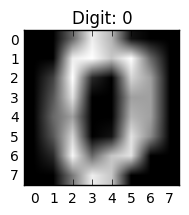

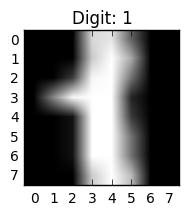

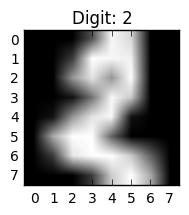

0 of 8 instances ready for connection; please wait, this takes a while... <(' ')>

In [8]:
X, y = load_digits(return_X_y=True)
X = np.asarray([x.flatten() for x in X])

for i in range(3):
    plt.imshow(X[i].reshape((8, 8)), cmap='Greys_r')
    plt.title('Digit: {}'.format(y[i]))
    plt.show()

# Train a NN to predict the numbers (as simple as it gets)
## This also demonstrates the time problem of adjusting hyper-parameters

---


In [9]:
pca = PCA(n_components=20)

print 'Features before: ', X.shape[1]

X = pca.fit_transform(X)

print 'Features after: ', X.shape[1]
print '{}% Explained Variance'.format(round(sum(pca.explained_variance_ratio_) * 100, 1))

Features before:  64
Features after:  20
89.4% Explained Variance
0 of 8 instances ready for connection; please wait, this takes a while... <(' ')>

Train with some given parameters...

In [12]:
lr = MLPClassifier(hidden_layer_sizes=(10, 5), batch_size=10,
                   solver='sgd', learning_rate_init=0.01, early_stopping=True)

start = time.time()
scores = cross_val_score(estimator=lr,
                         X=X, 
                         y=y,
                         cv=5)

print("\nAccuracy: {}% (+/- {})".format(round(scores.mean() * 100, 2), round(scores.std(), 3) * 2))
print('Finished in {}sec\n'.format(round(time.time() - start, 2)))


Accuracy: 79.43% (+/- 0.068)
Finished in 1.08sec

All 8 instances ready!
Setting node names...Done.
Installing Anaconda on cluster...

Done.

---
Alright, how about something else...

In [13]:
lr = MLPClassifier(hidden_layer_sizes=(10, 10,), batch_size=100,
                   solver='sgd', learning_rate_init=0.01, early_stopping=True)

start = time.time()
scores = cross_val_score(estimator=lr,
                         X=X, 
                         y=y,
                         cv=5)

print("\nAccuracy: {}% (+/- {})".format(round(scores.mean() * 100, 2), round(scores.std(), 3) * 2))
print('Finished in {}sec\n'.format(round(time.time() - start, 2)))


Accuracy: 86.83% (+/- 0.084)
Finished in 0.42sec



and now something different than that..

In [14]:
lr = MLPClassifier(hidden_layer_sizes=(10, 10, 10,), batch_size=100,
                   solver='sgd', learning_rate_init=0.01, early_stopping=True)

start = time.time()
scores = cross_val_score(estimator=lr,
                         X=X, 
                         y=y,
                         cv=5)

print("\nAccuracy: {}% (+/- {})".format(round(scores.mean() * 100, 2), round(scores.std(), 3) * 2))
print('Finished in {}sec\n'.format(round(time.time() - start, 2)))


Accuracy: 83.59% (+/- 0.072)
Finished in 0.44sec



## Issue: What hyper params are best? 

Train for all/most?

In [36]:

# Define hyper parameter ranges
batch_sizes = np.linspace(start=5, stop=750, num=25, dtype=np.int64)
n_layers = range(1, 15, 2)

# Make a list of all combinations
params = []
for batch_size in batch_sizes:
    for n_layer in n_layers:

        n_neuron = np.random.randint(low=5, high=200)
        params.append({'batch_size': batch_size,
                       'hidden_layer_sizes': tuple(n_neuron for _ in range(n_layer)),
                       'solver': 'sgd',
                       'learning_rate_init': 0.01,
                       'early_stopping': True
                      })

print '{} different combinations.'.format(len(params))
pprint(params[:2])

175 different combinations.
[{'batch_size': 5,
  'early_stopping': True,
  'hidden_layer_sizes': (13,),
  'learning_rate_init': 0.01,
  'solver': 'sgd'},
 {'batch_size': 5,
  'early_stopping': True,
  'hidden_layer_sizes': (63, 63, 63),
  'learning_rate_init': 0.01,
  'solver': 'sgd'}]


# This will take a while, even if using all cores on a local machine; let's distribute the workload

In [17]:
cluster.install_python_packages(['scikit-learn', 'numpy', 'pandas', 'dask', 'futures'], method='conda')


Installing package: scikit-learn
----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

Installing package: numpy
----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_node-6 	Exit code: 0

----------
cclyde_node-7 	Exit code: 0

Installing package: pandas
----------
cclyde_node-master 	Exit code: 0

----------
cclyde_node-1 	Exit code: 0

----------
cclyde_node-2 	Exit code: 0

----------
cclyde_node-3 	Exit code: 0

----------
cclyde_node-4 	Exit code: 0

----------
cclyde_node-5 	Exit code: 0

----------
cclyde_

True

In [18]:
cluster.launch_dask()

Installing dask.distributed on cluster

Node: cclyde_node-master exit code: 0
Node: cclyde_node-1 exit code: 0
Node: cclyde_node-2 exit code: 0
Node: cclyde_node-3 exit code: 0
Node: cclyde_node-4 exit code: 0
Node: cclyde_node-5 exit code: 0
Node: cclyde_node-6 exit code: 0
Node: cclyde_node-7 exit code: 0
Launching scheduler on master node...Done.

Launching workers...Done.

Scheduler should be available here: 54.144.228.219:8786
Web Dashboard should be available here: 54.144.228.219:8787

# Define functions which will be distributed to workers...

In [19]:
def get_data(kwargs):
    """
    Function which gets data and performs PCA on it.
    """
    from sklearn.datasets import load_digits
    from sklearn.decomposition import PCA
    import numpy as np
    
    X, y = load_digits(return_X_y=True)
    X = np.asarray([x.flatten() for x in X])
    pca = PCA(n_components=20)
    X = pca.fit_transform(X)
    
    return (kwargs, X, y)


def model_tester(package):
    """
    Function which is mapped to cluster. Passes kwargs to model to be trained.
    Returns score based on those kwargs.
    """
    
    kwargs, X, y = package
    
    import time
    import numpy as np
    from sklearn.linear_model import Perceptron
    from sklearn.model_selection import cross_val_score
    
    # Initialize model with given kwargs
    lr = MLPClassifier(**kwargs)
    scores = cross_val_score(estimator=lr,
                             X=X, 
                             y=y,
                             cv=5)
    return (kwargs, scores.mean(), scores.std())


def score_combiner(package):
    """
    Not needed, but more functions == more pretty colors
    """
    import time
    import random
    time.sleep(random.random())
    
    kwargs, score_m, score_std = package
    kwargs.update({'score': score_m, 'std': score_std})
    
    return kwargs


def double(n):
    '''
    Useless worker function # 1
    '''
    import time
    import random
    import sklearn
    time.sleep(random.random())
    return n * 2, 2


def add_two(package):
    """
    Useless worker function # 2
    """
    n, n2 = package
    import time
    import random
    time.sleep(random.random())
    return n + n2
    

# Define our client, locally or to the distributed cluster

In [20]:
c = Client()
c.restart()

<Client: scheduler="54.144.228.219:8786" processes=7 cores=7>

## Test out some test functions...

In [22]:
futures = c.map(double, range(250))
futures = c.map(add_two, futures)
progress(futures)

## Distribute the actual work

In [23]:
futures = c.map(get_data, params)
futures = c.map(model_tester, futures)
futures = c.map(score_combiner, futures)
progress(futures)

In [24]:
results = c.gather(futures)

In [25]:
df = pd.DataFrame(results)
df['n_layers'] = df.hidden_layer_sizes.map(lambda _tuple: len(_tuple)) 
df['n_neurons'] = df.hidden_layer_sizes.map(lambda _tuple: _tuple[0])
df.head()

,batch_size,early_stopping,hidden_layer_sizes,learning_rate_init,score,solver,std,n_layers,n_neurons
0,5,True,"(198,)",0.01,0.784703,sgd,0.045926,1,198
1,5,True,"(72, 72, 72)",0.01,0.822606,sgd,0.046332,3,72
2,5,True,"(8, 8, 8, 8, 8)",0.01,0.569634,sgd,0.034861,5,8
3,5,True,"(140, 140, 140, 140, 140, 140, 140)",0.01,0.873327,sgd,0.030680,7,140
4,5,True,"(192, 192, 192, 192, 192, 192, 192, 192, 192)",0.01,0.850143,sgd,0.052859,9,192


In [27]:
df.n_layers.unique()

array([ 1,  3,  5,  7,  9, 11, 13])

In [28]:

data = []
for n_layers in df.n_layers.unique():
    
    temp = df[df.n_layers == n_layers]
    
    trace = go.Scatter(
        x = temp.n_neurons,
        y = temp.n_layers,
        mode='markers',
        text=['{}%<br>Layers: {}'.format(round(v * 100, 2), l) 
              for v, l in zip(temp.score.values, temp.n_layers.values)],
        name='{} layers'.format(n_layers),
        marker=dict(
            size=temp.batch_size / 20.0,
            color = temp.score, #set color equal to a variable
            colorscale='Viridis',
            showscale=False
        )
    )
    data.append(trace)

layout = dict(title = 'Best performing models.<br>(size = batch size)',
              xaxis = dict(zeroline = False, title='Neuron Count'),
              yaxis = dict(zeroline = False, title='Layer Count'),
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')


In [29]:
df.ix[df.score.argmax(), :]

batch_size                                   98
early_stopping                             True
hidden_layer_sizes    (154, 154, 154, 154, 154)
learning_rate_init                         0.01
score                                  0.942668
solver                                      sgd
std                                   0.0255675
n_layers                                      5
n_neurons                                   154
Name: 23, dtype: object

# Also create a distributed queue system...

In [30]:
from Queue import Queue
local_q = Queue()
remote_q = c.scatter(local_q)

def long_calc1(n):
    
    import time
    import random
    
    time.sleep(random.random())
    
    return n + 2

def long_calc2(n):
    
    import time
    import random
    
    time.sleep(random.random())
    
    return n * 2

def long_calc3(n):
    
    import time
    import random
    
    time.sleep(random.random())
    
    return n - 2


long_calc1_q = c.map(long_calc1, remote_q)
long_calc2_q = c.map(long_calc2, long_calc1_q)
long_calc3_q = c.map(long_calc3, long_calc2_q)
result_q = c.gather(long_calc3_q)



## queue is currently empty...

In [33]:
result_q.qsize()

0

## Start submitting jobs to the queue with a thread

In [32]:
def start_jobs():

    jobs = range(500)

    for job in jobs:
        time.sleep(random.random())
        local_q.put(job)
        
    return 

thread = threading.Thread(target=start_jobs)
thread.start()

## and begin receiving the results...

In [34]:
def get_jobs():
    while True:
        print result_q.get()
        
    return

finish_thread = threading.Thread(target=get_jobs)
finish_thread.start()

2

4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304


In [35]:
cluster.terminate_cluster()

318
320
322
324
326


distributed.utils - ERROR - Stream is closed
Traceback (most recent call last):
  File "/home/milesg/anaconda2/envs/clusterclyde/lib/python2.7/site-packages/distributed/utils.py", line 130, in f
    result[0] = yield gen.maybe_future(func(*args, **kwargs))
  File "/home/milesg/anaconda2/envs/clusterclyde/lib/python2.7/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/home/milesg/anaconda2/envs/clusterclyde/lib/python2.7/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "/home/milesg/anaconda2/envs/clusterclyde/lib/python2.7/site-packages/tornado/gen.py", line 1021, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/milesg/anaconda2/envs/clusterclyde/lib/python2.7/site-packages/distributed/client.py", line 871, in _gather
    response = yield self.scheduler.gather(keys=keys)
  File "/home/milesg/anaconda2/envs/clusterclyde/lib/python2.7/site-packages/tornado/gen.py", line 1015, in run
    val